In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

C:\Users\VUHAI\.conda\envs\DataScience\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████████████████| 2.29G/2.29G [04:08<00:00, 9.89MB/s]

Extracting files...


Path to dataset files: C:\Users\VUHAI\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Augmentation cho training
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = "Data"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
#val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)

train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_test_transform

print(f"Training samples: {len(train_dataset)}, Valid samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),    # 128 -> 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),   # 64 -> 32
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2), # 32 -> 16
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),# 16 -> 8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                           # 256 * 8 * 8 = 16384
            nn.Linear(16384, 256), nn.ReLU(), nn.Dropout(0.5),   # ~4.2M
            nn.Linear(256, 64), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
model = CNNModel().to(device)
summary(model, input_size=(1, 128, 128))

Training samples: 3651, Valid samples: 1565, Test samples: 624
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 

In [19]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 10
train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}:")
    model.train()
    correct, total, loss_sum = 0, 0, 0
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.long().to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    train_acc.append(correct / total)
    train_loss.append(loss_sum / len(train_loader))
    print(f"Train acc: {correct / total}, Train loss: {loss_sum / len(train_loader)}")
    # Validation
    model.eval()
    val_correct, val_total, val_loss_sum = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.long().to(device)
            out = model(x)
            val_loss_sum += criterion(out, y).item()
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    val_acc.append(val_correct / val_total)
    val_loss.append(val_loss_sum / len(val_loader))
    scheduler.step(val_loss_sum / len(val_loader))
    print(f"Valid acc: {val_correct / val_total}, Valid loss: {val_loss_sum / len(val_loader)}")


C:\Users\VUHAI\.conda\envs\DataScience\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1:
Train acc: 0.835387565050671, Train loss: 0.4020546534139177
Valid acc: 0.9182108626198083, Valid loss: 0.20773947314948452
Epoch 2:
Train acc: 0.9383730484798686, Train loss: 0.17099964634879775
Valid acc: 0.9661341853035144, Valid loss: 0.13775938734108087
Epoch 3:
Train acc: 0.9550807997808819, Train loss: 0.12947924055725984
Valid acc: 0.9629392971246007, Valid loss: 0.10254824028483459
Epoch 4:
Train acc: 0.9734319364557655, Train loss: 0.07920655302561658
Valid acc: 0.923961661341853, Valid loss: 0.3198527130773481
Epoch 5:
Train acc: 0.9517940290331416, Train loss: 0.12875715261952397
Valid acc: 0.9699680511182108, Valid loss: 0.0873079991386253
Epoch 6:
Train acc: 0.9767187072035058, Train loss: 0.07004058111013602
Valid acc: 0.9769968051118211, Valid loss: 0.06992514532211484
Epoch 7:
Train acc: 0.9797315803889345, Train loss: 0.05513519146580897
Valid acc: 0.9271565495207668, Valid loss: 0.28039378000005166
Epoch 8:
Train acc: 0.9797315803889345, Train loss: 0.066882

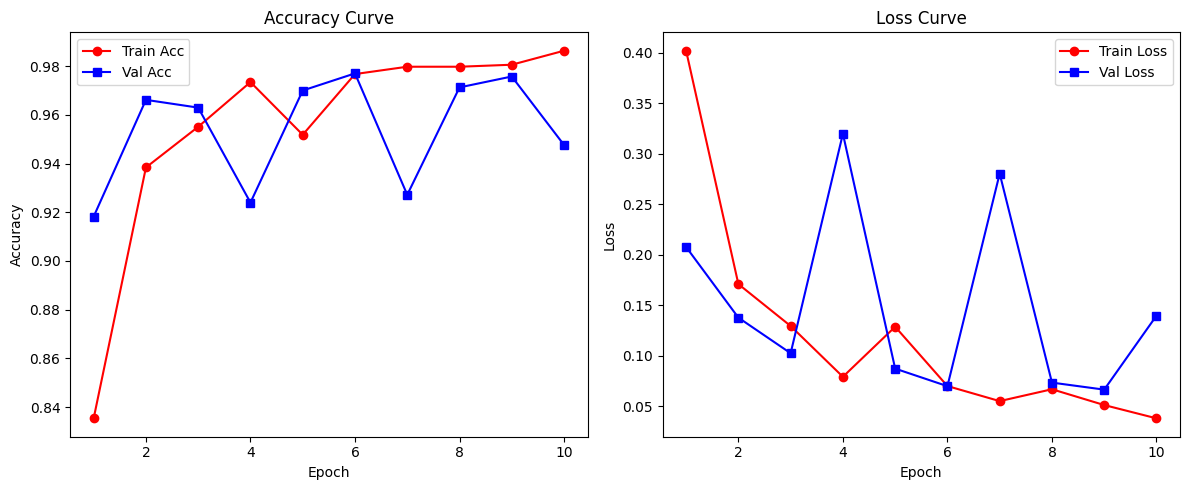

In [20]:
epochs = list(range(1, len(train_acc) + 1))

# Combined plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy subplotp
axes[0].plot(epochs, train_acc, 'r-o', label='Train Acc')
axes[0].plot(epochs, val_acc, 'b-s', label='Val Acc')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss subplot
axes[1].plot(epochs, train_loss, 'r-o', label='Train Loss')
axes[1].plot(epochs, val_loss, 'b-s', label='Val Loss')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.savefig("train_val_metrics_CNN.png")  # Save the figure
plt.show()


In [21]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
loss_test = criterion(torch.tensor(out.cpu().numpy()), torch.tensor(y)).item()

print(f"Test Accuracy: {acc:.4f}, Precision: {prec:.4f}, F1: {f1:.4f}, Loss: {loss_test:.4f}")
print(classification_report(all_labels, all_preds, target_names=['NORMAL', 'PNEUMONIA'], zero_division=0))

Test Accuracy: 0.8205, Precision: 0.7884, F1: 0.8716, Loss: 0.1153
              precision    recall  f1-score   support

      NORMAL       0.93      0.56      0.70       234
   PNEUMONIA       0.79      0.97      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624



C:\Users\VUHAI\AppData\Local\Temp\ipykernel_39008\120999800.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_test = criterion(torch.tensor(out.cpu().numpy()), torch.tensor(y)).item()


In [22]:
import numpy as np
print("Unique predicted labels:", np.unique(all_preds))
print("Label counts:", pd.Series(all_preds).value_counts())

Unique predicted labels: [0 1]
Label counts: 1    482
0    142
Name: count, dtype: int64


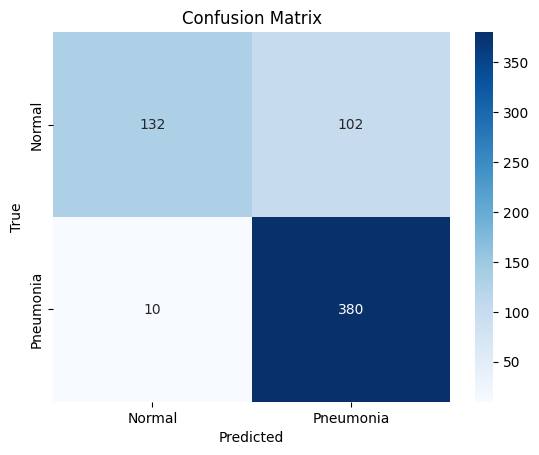

In [23]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [11]:
PATH = "./Model/CNN.pth"
torch.save(model.state_dict(), PATH)

RuntimeError: Parent directory ./Model does not exist.